In [5]:
# Import data and libraries
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import pandas as pd
import matplotlib
import matplotlib.pylab as pylab

import sys
#sys.path.append('../Bmore/2015/') 
sys.path.append('../Bmore/')

import spatialfunctions

#from mpl_toolkits.basemap import Basemap
pylab.rcParams['figure.figsize'] = 16, 12
#pd.options.display.mpl_style = 'default'
matplotlib.style.use('ggplot') # for pandas version 17
#get_ipython().magic(u'matplotlib inline')
import sys 
#sys.path.append('../Bmore/2015')
#import ibuttonplots
import importibuttondata
pylab.rcParams['font.family'] = 'serif' 
pylab.rcParams['font.size'] = 14
pylab.rcParams['axes.titlesize'] = 22

### Use this to read in reformated data 
tempDF = pd.read_csv('NairobiSensors.csv', parse_dates = [0]).set_index('Date')
tempDF.columns = tempDF.columns.astype(int)
meta = pd.DataFrame(pd.read_csv('./data/metaNairobi.csv', sep = ','))
meta = meta.set_index(meta['sensornumber'])

availablesensors = np.intersect1d(meta.index, tempDF.columns)
meta = meta.loc[availablesensors]
tempDF = tempDF[availablesensors]

/Users/annascott2/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:25: FutureWarning: 
mpl_style had been deprecated and will be removed in a future version.
Use `matplotlib.pyplot.style.use` instead.



In [ ]:
# cleaned data : drop 30, 36, 46 
# ones on metal: 5, 19, 33, 39, 40


In [6]:
drop_sensors = [5, 19, 33, 39, 40, 30, 36, 46 ]
selected = np.setdiff1d(meta.sensornumber.values, drop_sensors)

In [7]:
tempDF = tempDF[selected]
meta = meta.loc[selected]

In [7]:
import sys
sys.path.append('../Bmore/2015/') 
import spatialfunctions
# lon = meta['location:Longitude'].values
# lat = meta['location:Latitude'].values

# rasterfile = 'data/LC81680612015053LGN00_B10.TIF'#'../satellite/data/atm_cor_10_LC80150332015229.tif'
# band10 = spatialfunctions.extract_raster_values(lon,lat, rasterfile)
# LST = spatialfunctions.band10_toLST(band10)

In [8]:
lon = meta['location:Longitude'].values
lat = meta['location:Latitude'].values

rasterfile = 'data/LC81680612015053LGN00_B10.TIF'#'../satellite/data/atm_cor_10_LC80150332015229.tif'
band10 = spatialfunctions.extract_raster_values(lon,lat, rasterfile)
LST = spatialfunctions.band10_toLST(band10)

#path = '../../satellite/data/BaltimoreLandsatSummer2015/L8 OLI_TIRS/LC80150332015229LGN00/'
path = '../satellite/data/Nairobi/L8OLI_TIRS/LC81680612015053LGN00/'
B = np.zeros((5,lon.shape[0]))
for i in (1,2,3,4,5): 
    file = path+ 'LC81680612015053LGN00_B'+'%s'%i +'.TIF'
    DN = spatialfunctions.extract_raster_values(lon,lat,file)
    # convert from digital number to toa reflectance  using : rho*\lambda = REFLECTANCE_MULT_BAND_x*DN +REFLECTANCE_ADD_BAND_x
    reflectance_mult_band = 2.000e-5
    reflectance_add_band  = -0.100000
    B[i-1, :] = reflectance_mult_band*DN+reflectance_add_band

alb = spatialfunctions.albedo(B[0,:], B[1,:], B[2,:], B[3,:], B[4,:], )
alb[alb>1] = 'NaN'
alb[alb<0] = 'NaN'

NDVI = (B[4,:]-B[3,:]) / (B[4,:]+B[3,:])

rasterfile = 'data/s02_e036_1arc_v3.tif'
elevation = spatialfunctions.extract_raster_values(lon,lat, rasterfile)

AttributeError: 'NoneType' object has no attribute 'GetGeoTransform'

In [9]:
alb.shape, LST.shape, elevation.shape

((35,), (35,), (35,))

In [12]:
tempDF.resample('D').mean().min().shape

(35,)

In [15]:
df = pd.DataFrame({"Temp": tempDF.resample('D').max().mean(), # tempDF.resample('D').min(),
                   "Elevation": elevation, 
                   "LST": LST, 
                   "albedo": alb, 
                    })
df.corr()

,Elevation,LST,Temp,albedo
Elevation,1.000000,-0.287383,-0.425709,-0.357143
LST,-0.287383,1.000000,0.487488,-0.535749
Temp,-0.425709,0.487488,1.000000,0.012391
albedo,-0.357143,-0.535749,0.012391,1.000000


In [47]:
df = pd.DataFrame({"Temp": tempDF.mean(), "Elevation": elevation, 
                   "LST": LST, 
                   "albedo": alb, 
                    })
df.corr()

,Elevation,LST,Temp,albedo
Elevation,1.000000,-0.287383,-0.535574,-0.357143
LST,-0.287383,1.000000,0.622686,-0.535749
Temp,-0.535574,0.622686,1.000000,-0.026494
albedo,-0.357143,-0.535749,-0.026494,1.000000


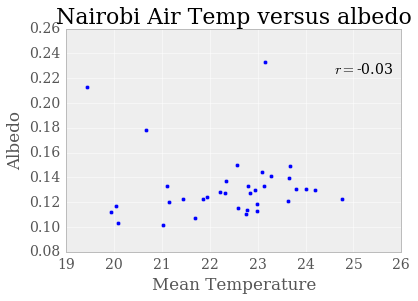

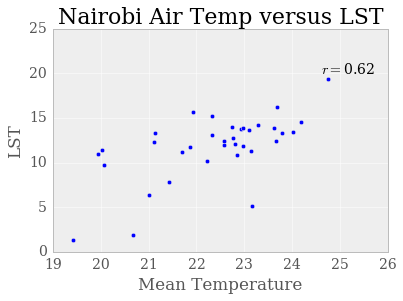

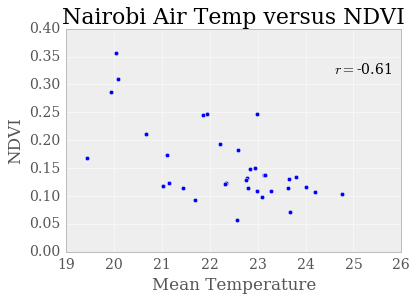

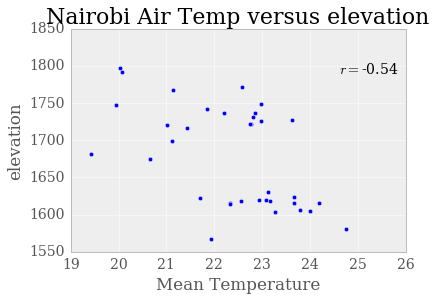

In [48]:
plt.scatter(tempDF.mean(), alb)
plt.xlabel('Mean Temperature')
plt.ylabel('Albedo')
plt.title('Nairobi Air Temp versus albedo')
r = np.corrcoef(tempDF.mean(), alb)[0,1]
plt.annotate('$r=$%.2f'%r, xy=(.8, .8), xycoords ='axes fraction')

plt.figure()
plt.scatter(tempDF.mean(), LST)
plt.xlabel('Mean Temperature')
plt.ylabel('LST')
plt.title('Nairobi Air Temp versus LST')
r = np.corrcoef(tempDF.mean(), LST)[0,1]
plt.annotate('$r=$%.2f'%r, xy=(.8, .8), xycoords ='axes fraction')


plt.figure()
plt.scatter(tempDF.mean(), NDVI)
plt.xlabel('Mean Temperature')
plt.ylabel('NDVI')
plt.title('Nairobi Air Temp versus NDVI')
r = np.corrcoef(tempDF.mean(), NDVI)[0,1]
plt.annotate('$r=$%.2f'%r, xy=(.8, .8), xycoords ='axes fraction')

plt.figure()
plt.scatter(tempDF.mean(), elevation)
plt.xlabel('Mean Temperature')
plt.ylabel('elevation')
plt.title('Nairobi Air Temp versus elevation')
r = np.corrcoef(tempDF.mean(), elevation)[0,1]
plt.annotate('$r=$%.2f'%r, xy=(.8, .8), xycoords ='axes fraction')

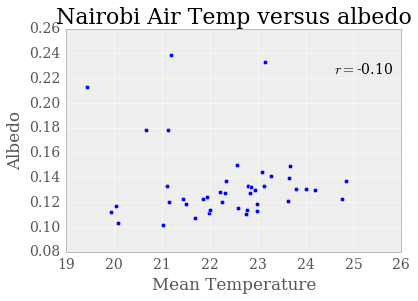

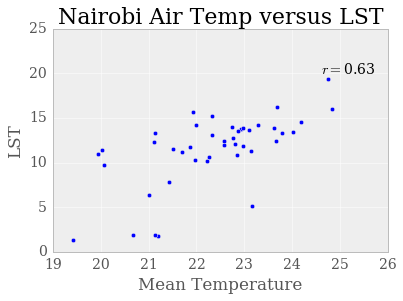

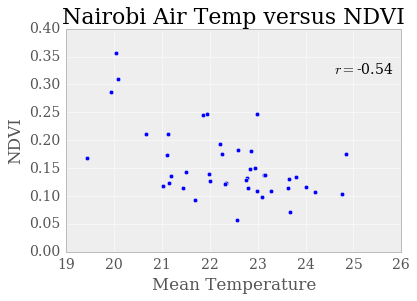

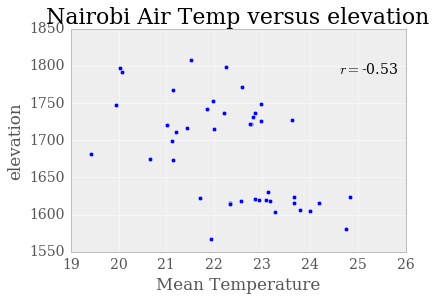

In [17]:
plt.scatter(tempDF.mean(), alb)
plt.xlabel('Mean Temperature')
plt.ylabel('Albedo')
plt.title('Nairobi Air Temp versus albedo')
r = np.corrcoef(tempDF.mean(), alb)[0,1]
plt.annotate('$r=$%.2f'%r, xy=(.8, .8), xycoords ='axes fraction')

plt.figure()
plt.scatter(tempDF.mean(), LST)
plt.xlabel('Mean Temperature')
plt.ylabel('LST')
plt.title('Nairobi Air Temp versus LST')
r = np.corrcoef(tempDF.mean(), LST)[0,1]
plt.annotate('$r=$%.2f'%r, xy=(.8, .8), xycoords ='axes fraction')


plt.figure()
plt.scatter(tempDF.mean(), NDVI)
plt.xlabel('Mean Temperature')
plt.ylabel('NDVI')
plt.title('Nairobi Air Temp versus NDVI')
r = np.corrcoef(tempDF.mean(), NDVI)[0,1]
plt.annotate('$r=$%.2f'%r, xy=(.8, .8), xycoords ='axes fraction')

plt.figure()
plt.scatter(tempDF.mean(), elevation)
plt.xlabel('Mean Temperature')
plt.ylabel('elevation')
plt.title('Nairobi Air Temp versus elevation')
r = np.corrcoef(tempDF.mean(), elevation)[0,1]
plt.annotate('$r=$%.2f'%r, xy=(.8, .8), xycoords ='axes fraction')

#plt.scatter(tempDF.mean(),elevation)